# IDA_ML_ss22 Semester Project: Project 5 -- Spam

Author: 815202 Chung-Fan Tsai

Problem: 
You have been hired by the IT department of a medium-sized company to train an email
spam filter which should mark the incoming emails of all employees as spam or non-spam.

# Problem Formalisation

Task (T): Classify an email into spam or not spam

Experience (E): A corpus of extracted employee emails (size=10,000) labeled spam or not spam

Performance (P): Maximizing True Positive ("identify a maximum number of spam emails"), with False Positive Rate less than 0.2% ("a maximum of 0.2% of all legitimate
emails being classified incorrectly")

## Problem Analysis

As our data is fully labeled in discrete values (+1, -1), it is better suited for supervised learning and training a classificatier.

## Target Variable (Label)
2 classes, +1 stands for spam, −1 non-spam

## Input Attributes
Emails in the data have been converted to bag-of-words representation, with a total of 57,173 different unique words (or features). However, we do not have the lookup table of what word each index indicates, we also have no knowledge of how data preprocessing was conducted (undercasing? stopword removing?).


# Data Exploration and Visualization

missing values (decide how to deal with them and provide a rationale for your decision) or the quantity of data for each label.

We first want to import python packages we need for this project, and read into data from the emails.mat file for exploration.

In [4]:
# general pacakges
import scipy.io 
import numpy as np 
import pandas as pd
import scipy.sparse
import os
import json
import random
import time
import yaml
import math

# packages to save RAM when running module on Jupyter
import gc 

# plotting packages
from matplotlib import pyplot as plt
from matplotlib.pyplot import rcParams
rcParams['figure.figsize'] = 14, 8

# normalization
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import normalize

# model related packages
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import PrecisionRecallDisplay
import tensorflow as tf
from tensorflow import keras
from sklearn.utils import class_weight
from sklearn.linear_model import Perceptron


# normalization
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import normalize

# Precision/recall curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

# torch packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')


SEED = 8 # after some testing this one seems to work very well
random.seed(SEED)

data = scipy.io.loadmat('../input/emails/emails.mat') 
print(data)


{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN, Created on: Tue Dec 07 13:57:47 2010', '__version__': '1.0', '__globals__': [], 'X': <57173x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 2351499 stored elements in Compressed Sparse Column format>, 'Y': array([[ 1, -1,  1, ...,  1,  1,  1]], dtype=int16)}


In [5]:
# we first look at how X and Y are stored (data type) and shaped
X_raw = data['X']
Y_raw = data['Y']
print(X_raw, type(X_raw), X_raw.shape)
print(Y_raw, type(Y_raw), Y_raw.shape)

  (957, 0)	1.0
  (2164, 0)	1.0
  (2603, 0)	1.0
  (2925, 0)	1.0
  (2939, 0)	1.0
  (3010, 0)	3.0
  (3021, 0)	3.0
  (3330, 0)	1.0
  (3577, 0)	1.0
  (4148, 0)	1.0
  (4506, 0)	1.0
  (5193, 0)	1.0
  (6595, 0)	3.0
  (6799, 0)	1.0
  (6897, 0)	1.0
  (7237, 0)	2.0
  (7304, 0)	1.0
  (7567, 0)	1.0
  (9590, 0)	3.0
  (11570, 0)	1.0
  (11702, 0)	2.0
  (11826, 0)	1.0
  (11965, 0)	3.0
  (12246, 0)	4.0
  (12442, 0)	1.0
  :	:
  (49154, 9999)	2.0
  (49216, 9999)	1.0
  (49476, 9999)	1.0
  (49515, 9999)	5.0
  (49832, 9999)	1.0
  (50228, 9999)	2.0
  (50575, 9999)	2.0
  (50752, 9999)	2.0
  (50803, 9999)	4.0
  (51154, 9999)	2.0
  (51332, 9999)	2.0
  (51580, 9999)	1.0
  (51854, 9999)	2.0
  (52354, 9999)	2.0
  (52431, 9999)	1.0
  (52725, 9999)	1.0
  (52836, 9999)	4.0
  (52948, 9999)	2.0
  (53318, 9999)	1.0
  (54075, 9999)	8.0
  (54150, 9999)	4.0
  (55717, 9999)	4.0
  (55792, 9999)	2.0
  (55908, 9999)	1.0
  (56173, 9999)	2.0 <class 'scipy.sparse.csc.csc_matrix'> (57173, 10000)
[[ 1 -1  1 ...  1  1  1]] <class 'nu

So we know X is a sparse matrix of 57173 x 10000, we can use todense to decompress it to turn it into a numpy array. As we want rows to represent email entry and column for features, we'll transpose it.
For Y, we want to have rows of individual label to match the email etnries in X, so we'll reshape it:

In [6]:
X, Y = np.asarray(data['X'].todense().transpose()), data['Y'].reshape(-1)
print(type(X), X.shape, type(Y), Y.shape)

<class 'numpy.ndarray'> (10000, 57173) <class 'numpy.ndarray'> (10000,)


In [8]:


# # split the data
# # X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size= 0.9, random_state = SEED)

# # train, test, validation set split we choose to be 70% 15% 15%
# # first split the data in training and remaining dataset
# # X_train, X_rest, y_train, y_rest = train_test_split(X,Y, train_size=0.7, random_state = SEED)
# # # then define valid_size and test set=0.5 
# # X_valid, X_test, y_valid, y_test = train_test_split(X_rest, y_rest, test_size=0.5, random_state = SEED)


# # stratify parameter makes a split so that the proportion of values in the sample produced will be the same as the proportion of values provided to parameter 
# X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=.7 , stratify=Y,random_state=SEED)


## Data analysis
* check missing or erroneous data
* understand units/presentation
* check if feature selection is necessary

We know that X is in BOW presentation, but just in case, we should check if there are none +1/-1 values and or if there's nan entries, same goes for Y:

In [20]:
print("--------- X ---------")
print("How many values/count are < 0, meaning erroreous count?",X[X < 0].size)
print("Is there any entry that is not a numpy array or is empty, meaning missing entry?",len([1 for x in X if not isinstance(X, np.ndarray)])>0 or len([1 for x in X if len(X)<1])>0)

print("--------- Y ---------")
print("How many values/count are < 0, meaning erroreous count?",Y[abs(Y)!= 1].size)
print("Is there any entry that is nan, meaning missing entry?",any(np.isnan(y) for y in Y.flatten()))


--------- X ---------
How many values/count are < 0, meaning erroreous count? 0
Is there any entry that is not a numpy array or is empty, meaning missing entry? False
--------- Y ---------
How many values/count are < 0, meaning erroreous count? 0
Is there any entry that is nan, meaning missing entry? False


Even though we don't know what the attributes are as in words, we still want to get a general idea of the size of emails, how frequent can a word appear in one email...etc:

In [7]:
print("--------- X ---------")
print("How many labels are == 0, meaning how sparse?",X[X == 0].size)
print("How many labels are == 1, meaning a word appears only once?",X[X == 1].size)
print("How many labels are > 1, meaning how many times a word appears more than once?",X[X > 1].size)

X_dataframe = pd.DataFrame(X)

print("Most frequent word appeared how many times?",X_dataframe.max(numeric_only=True).max())
print("Minimum word count should be?", X_dataframe.min(numeric_only=True).min())

max_idx = X_dataframe.max(numeric_only=True).idxmax()
print("Which word/column has the max word count?", max_idx)
print("Is it true that that's the max value?", X_dataframe[max_idx].max() == X_dataframe.max(numeric_only=True).max())


--------- X ---------
How many labels are == 0, meaning how sparse? 569378501
How many labels are == 1, meaning a word appears only once? 1386433
How many labels are > 1, meaning how many times a word appears more than once? 965066
Most frequent word appeared how many times? 1343.0
Minimum word count should be? 0.0
Which word/column has the max word count? 23712
Is it true that that's the max value? True


So we learn that in our BoW presentation, word count range is [0, 1343], with the 23712th word appears the most in one email

In [9]:
word_per_email = np.sum(X, axis=1)
word_per_email_dataframe = pd.DataFrame(word_per_email)
print(word_per_email_dataframe.describe())


                  0
count  10000.000000
mean     562.005800
std      802.424727
min        4.000000
25%      186.000000
50%      369.000000
75%      770.000000
max    13933.000000


Turning word per email count into a dataframe and get a summary of it, we know that the length of each email is in the range of [4,13933], and the average amount of words per email is 562.

To see whether there are a lot of emails with few words or long essays, we want to see the distribution of it in a different way:

In [10]:
num_of_words = [5,10,30,100,500,1000,5000,10000]
for num in num_of_words:
    if num < 1001:
        print("How many emails have less than ",num," words?", word_per_email[word_per_email < num].size)
    else:
        print("How many emails have more than ",num," words?", word_per_email[word_per_email > num].size)


How many emails have less than  5  words? 2
How many emails have less than  10  words? 15
How many emails have less than  30  words? 91
How many emails have less than  100  words? 1164
How many emails have less than  500  words? 5795
How many emails have less than  1000  words? 9265
How many emails have more than  5000  words? 73
How many emails have more than  10000  words? 12


So we know most emails have the expected amount of words (not too few, not too many).

Then we also want to know how many email extracted/labeled is spam:

In [12]:
print("There are ",Y[Y==-1].size, " non-spam emails, meaning ", Y[Y==-1].size/Y.size*100,"% of the emails in data are non-spam.")
print("There are ",Y[Y==1].size, " spam emails, meaning ", Y[Y==1].size/Y.size*100,"% of the emails in data are spam.")


There are  1970  non-spam emails, meaning  19.7 % of the emails in data are non-spam.
There are  8030  spam emails, meaning  80.30000000000001 % of the emails in data are spam.


# Feature selection 
While we have a lot of features (or unique word counts), we cannot really perform feature selection by removing or combing some attributes (like selecting spammy word combinations) as we do not has access to the original words. That being said, we still want to check if there are very common words that appear in many emails:

In [13]:
# check if there is one word feature that appears in all emails
count = 0
for col in X_dataframe.columns:
    if (X_dataframe[col] != 0).all():
        count += 1
print("Number of words that appear in every email: ", count)

# check if there are words/features that appear in A LOT of the emails
count_list = []
for col in X_dataframe.columns:
    count_list.append(X_dataframe[col][X_dataframe[col] > 0].size)

print("Most document frequent word appears in how many emails? ", max(count_list))

word_doc_freq = [5000,7500,9000, 9500]
for freq in word_doc_freq:
    print("How many words appear in more than ",freq, " number of emails? ", len([i for i in count_list if i > freq]))

Number of words that appear in every email:  0
Most document frequent word appears in how many emails?  9993
How many words appear in more than  5000  number of emails?  25
How many words appear in more than  7500  number of emails?  4
How many words appear in more than  9000  number of emails?  1
How many words appear in more than  9500  number of emails?  1


From our word document frequency study, we learn that some 25 words do appear in more than half of the emails, but very few of them appear in more than 3/4 of the emails. We assume the ones that do (only 4 of them) are really common words (even though we aren't sure whether stop words were filtered out before being turned into BoW presentation. We assume that as we have around 80% spam emails, those common words could also be words frequently used in spam mails.

As we do not have the original emails to confirm this, we will not exclude any word/feature (regardless of its frequency). 

And as we got features in the form of BoW, we do not know the order of them, so there's no point of doing n-gram or create new composit feature. 

## Model Selection


Now that we've checked there's no missing value and probably no errorneous values.
And we are ok with the units and presentation of the data
as the words are already inputted as BoW presentation,
we do not have to preprocess them. It's time to decide a model
because they are all labeled, and target value is binary (discrete) and not ranked/ordered nor structured, we are going to perform supervised classification.

To utilize some models we've learned in the course, we'll apply the following models:
* Decision Tree
* Random Forest
* Linear Regression
* MLP

## Data split

We'll be training with 70% of the data, use validation set of 15% to tune, and 15% of test to evaluate. The reason for this split is we want as many data to train but also enough to tune and test.

In [3]:
# split the data, as we have very imbalanced data, we use stratify to make sure the split includes same proportion of both classes
X_train, X_rest, y_train, y_rest = train_test_split(X, Y, train_size= 0.7, stratify=Y, random_state = SEED)
X_test, X_validation, y_test, y_validation = train_test_split(X_rest, y_rest, train_size= 0.5, stratify=y_rest, random_state = SEED)

print(X_train.shape, X_validation.shape, X_test.shape)


# for spam detection, it's worse to identify legitimate mail as spam (false positive)
# out of all non-spam emails, less than .2% of them can be mislabeled
def countFalsePositiveRate(pred,label, non_spam = -1):
    return (((label == non_spam) & (pred == 1)).sum()) / len(label==non_spam) * 100


fprs, scores = [], []

(7000, 57173) (1500, 57173) (1500, 57173)


# Model 1: Decision Tree

In fact, multiple studies (https://www.itm-conferences.org/articles/itmconf/pdf/2022/02/itmconf_icacs2022_01001.pdf) indicate using decision tree to classify spam is quite effective and
efficient. Not to mention, it's a simple, efficient, scalable learning algorithm, and works for large sample sizes. It can also create complex nonlinear models and works for classification & regression problems.

In [2]:

n_depth = np.arange(20,30,1)
accs_valid = []
accs_train = []

# tuning with max_depth (had to batch it 'cause even colab wasn't able to run this tuning it on GPU)
for max_depth in n_depth:
    clf_tree = DecisionTreeClassifier(criterion='entropy', max_depth=max_depth, random_state=SEED)
    clf_tree.fit(X_train, y_train)
    valid_score = clf_tree.score(X_validation, y_validation)
    accs_valid.append(valid_score)
    train_score = clf_tree.score(X_train, y_train)
    accs_train.append(train_score)
    print("max_depth:",max_depth , " ; training score:",train_score, " ; validation score:", valid_score)
    del clf_tree
    gc.collect
    

max_depth: 20  ; training score: 0.9988571428571429  ; validation score: 0.9913333333333333
max_depth: 21  ; training score: 0.9988571428571429  ; validation score: 0.99
max_depth: 22  ; training score: 0.9992857142857143  ; validation score: 0.992
max_depth: 23  ; training score: 0.9994285714285714  ; validation score: 0.9913333333333333
max_depth: 24  ; training score: 0.9995714285714286  ; validation score: 0.99
max_depth: 25  ; training score: 0.9997142857142857  ; validation score: 0.992
max_depth: 26  ; training score: 0.9998571428571429  ; validation score: 0.9906666666666667
max_depth: 27  ; training score: 0.9998571428571429  ; validation score: 0.9906666666666667
max_depth: 28  ; training score: 0.9998571428571429  ; validation score: 0.9906666666666667
max_depth: 29  ; training score: 0.9998571428571429  ; validation score: 0.9906666666666667


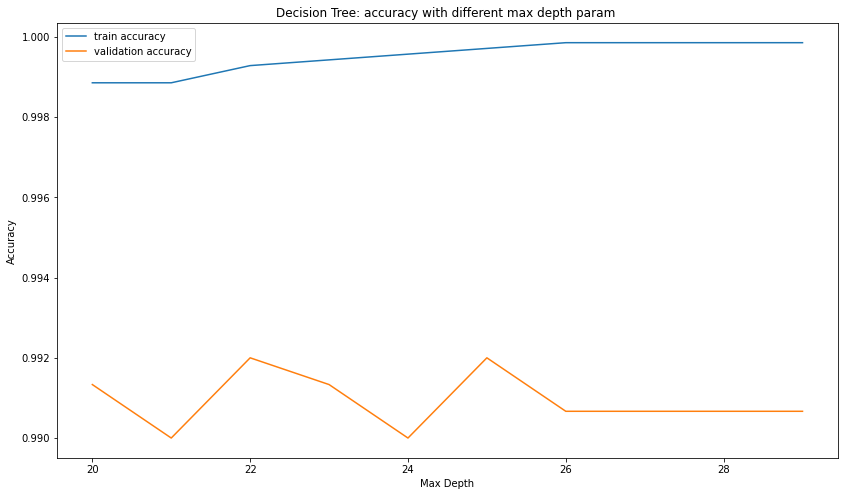

In [3]:
# plot
# figure(figsize=(12, 6), dpi=80)
plt.plot(n_depth,accs_train, label='train accuracy')
plt.plot(n_depth,accs_valid, label='validation accuracy')
plt.title("Decision Tree: accuracy with different max depth param ")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [27]:
idx_of_best_tree = np.argmax(np.array(accs_valid))
max_depth = n_depth[idx_of_best_tree]
clf_tree = DecisionTreeClassifier(criterion='entropy', max_depth=max_depth, random_state=SEED)
clf_tree.fit(X_train, y_train)
pred = clf_tree.predict(X_test) 
fpr = countFalsePositiveRate(pred,y_test)
score = clf_tree.score(X_test, y_test)
print("After tuning, the best performing tree has max depth of ", n_depth[idx_of_best_tree])
print("FPR of our best perfomring decision tree is:", fpr ,"%")
print("And it has an entropy score of: ", score)


After tuning, the best performing tree has max depth of  22
FPR of our best perfomring decision tree is: 0.4 %
And it has an entropy score of:  0.9873333333333333


In [ ]:
FPRs.append(fpr)
scores.append(score)

## Decision Tree analysis

Since we couldn't reach FPR of lower than .2%, DT might be too simple (or we need much more tuning), but we'll try a less interpretable but easy to implement Random Forest.

# Model 2: Random Forest 

We want to also utilize Random Forest because of our little data size as it is a powerful non-linear classifier, it's quick & easy to apply, and performs well, it is often used as quick fix when no huge training data for NN. 

The implementation of the random forest algorithm in sklearn has many parameter. The most important ones are the number of trees used (n_estimators) and the maximal depth of a single tree (max_depth). Investigate how the number of used trees effects the training and testing accuracy.  

In [43]:
n_depth = np.arange(26,38,1)
n_trees = np.arange(33,35,1)

accs_valid_hyper = []
accs_train_hyper = []
DT_params_hyper = []
for tree in n_trees:
    for max_depth in n_depth:
        model = RandomForestClassifier(criterion='entropy', n_estimators = tree, max_depth=max_depth, random_state=SEED)
        model.fit(X_train, y_train)
        valid_score = model.score(X_validation, y_validation)
        accs_valid_hyper.append(valid_score)
        train_score = model.score(X_train, y_train)
        accs_train_hyper.append(train_score)
        DT_params_hyper.append((tree,max_depth))
        print("n_estimators:",tree , " ; max_depth:",max_depth , " ; training score:",train_score, " ; validation score:", valid_score)
        del model
        gc.collect

n_estimators: 33  ; max_depth: 26  ; training score: 0.997  ; validation score: 0.9953333333333333
n_estimators: 33  ; max_depth: 27  ; training score: 0.9967142857142857  ; validation score: 0.996
n_estimators: 33  ; max_depth: 28  ; training score: 0.9972857142857143  ; validation score: 0.996
n_estimators: 33  ; max_depth: 29  ; training score: 0.997  ; validation score: 0.9946666666666667
n_estimators: 33  ; max_depth: 30  ; training score: 0.9971428571428571  ; validation score: 0.994
n_estimators: 33  ; max_depth: 31  ; training score: 0.9971428571428571  ; validation score: 0.994
n_estimators: 33  ; max_depth: 32  ; training score: 0.9975714285714286  ; validation score: 0.9946666666666667
n_estimators: 33  ; max_depth: 33  ; training score: 0.9974285714285714  ; validation score: 0.996
n_estimators: 33  ; max_depth: 34  ; training score: 0.9975714285714286  ; validation score: 0.9953333333333333
n_estimators: 33  ; max_depth: 35  ; training score: 0.998  ; validation score: 0.9

we see that 6 (or 12) estimate tree is the best

In [44]:
idx_of_best_hyperparam = np.argmax(np.array(accs_valid_hyper))
tree, max_depth = DT_params_hyper[idx_of_best_hyperparam][0], DT_params_hyper[idx_of_best_hyperparam][1]
model = RandomForestClassifier(criterion='entropy', n_estimators = tree, max_depth=max_depth, random_state=SEED)
model.fit(X_train, y_train)
pred = model.predict(X_test) 
score = model.score(X_test, y_test)
fpr = countFalsePositiveRate(pred,y_test)
print("After tuning, the best performing Random Forest has max depth of ", max_depth, "and ", tree, " estimators.")
print("FPR of our best perfomring model is:", fpr ,"%")
print("And it has an entropy score of: ", score)
del model
gc.collect


After tuning, the best performing Random Forest has max depth of  37 and  34  estimators.
FPR of our best perfomring model is: 0.26666666666666666 %
And it has an entropy score of:  0.996


<function gc.collect(generation=2)>

In [ ]:
FPRs.append(fpr)
scores.append(score)


## Random Forest analysis

We see that even with something as simple as Random Forest, we still were able to achieve amazing result wiht some hyperparameter tuning.




# Model 3: Linear classification


In [5]:
def learn_reg_ERM(X,y,lbda, print_loss): 
    max_iter = 200
    e  = 0.001
    alpha = 1.

    w = np.random.randn(X.shape[1]);
    for k in np.arange(max_iter):
        h = np.dot(X,w)
        l,lg = loss(h, y)
        if print_loss:
            print ('loss: {}'.format(np.mean(l)))
        r,rg = reg(w, lbda) # r (regularization term) should be added to our prediction, we indirectly use regularization by using regularization gradient
        # so we don't really use r, but use reg gradient in the next line
        g = np.dot(X.T,lg) + rg # calculating minimization term
        if (k > 0):
            alpha = alpha * (np.dot(g_old.T,g_old))/(np.dot((g_old - g).T,g_old)) 
        w = w - alpha * g
        if (np.linalg.norm(alpha * g) < e):
            break
        g_old = g
    
    return w


def loss(h, y): # y is actual, h is predicted
    '''
    hinge loss
    is a loss function used for training classifiers
    is used for "maximum-margin" classification
    '''
    # calculate hinge loss: max(0, 1 - yihi) 
    loss = np.maximum(0, 1 - y*h)

    # gradients of the hinge loss wrt h: gi = -y if li > 0 else gi = 0
    loss_gradient = -y * (loss > 0) 

    return loss, loss_gradient

def reg(w, lbda):   
    '''
    regularization
    computes the  2 -regularizer and the gradient of the regularizer function at point  𝐰
    '''
    r = ( lbda / 2 ) * np.transpose(w) * w
    g = lbda * w
    return r, g

def predict(w,X):
    '''
     predicts the class label  𝑦  for a data point  𝐱  or a matrix  𝑋  of data points (row-wise) 
     for a previously trained linear model  𝐰
    '''
    preds = 2*(np.dot(X,w)>0) -1
    return preds

def linearClassifier(X_train, y_train, X_valid, y_valid, lbda, print_loss):
    print("---------- lbda: ", lbda, " -----------")
    w = learn_reg_ERM(X_train, y_train, lbda = lbda, print_loss = print_loss) # if you choose .5 can have low accuracy (60)
    preds = predict(w, X_train)
    train_acc = 100.0 * np.sum(preds == y_train) / len(y_train)
    print ("Train Accuracy: ", train_acc)
    preds = predict(w, X_valid,)
    valid_acc = 100.0 * np.sum(preds == y_valid,) / len(y_valid,)
    print ("Validation Accuracy: ", valid_acc)
    del w
    gc.collect
    return train_acc, valid_acc

In [7]:
train_acc_lst = []
valid_acc_lst = []
lbda_lst = [.005, .05, .5, 1, 5]

for lbda in lbda_lst:
    train_acc, valid_acc = linearClassifier(X_train, y_train, X_validation, y_validation, lbda, print_loss=False)
    train_acc_lst.append(train_acc)
    valid_acc_lst.append(valid_acc)


---------- lbda:  0.005  -----------
Train Accuracy: {} 97.8
Validation Accuracy: {} 96.8
---------- lbda:  0.05  -----------
Train Accuracy: {} 98.84285714285714
Validation Accuracy: {} 98.26666666666667
---------- lbda:  0.5  -----------
Train Accuracy: {} 98.8
Validation Accuracy: {} 98.4
---------- lbda:  1  -----------
Train Accuracy: {} 95.42857142857143
Validation Accuracy: {} 95.13333333333334
---------- lbda:  5  -----------
Train Accuracy: {} 98.51428571428572
Validation Accuracy: {} 98.0


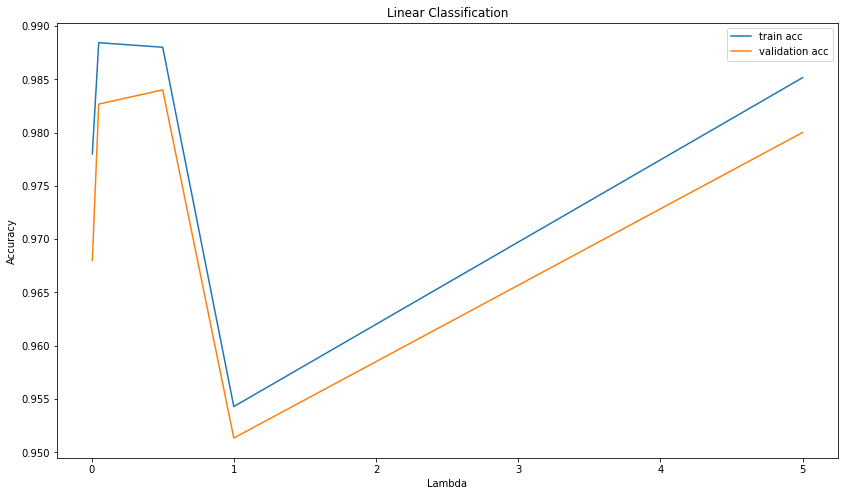

In [11]:
plt.plot(lbda_lst, [a/100 for a in train_acc_lst], label='train acc')
plt.plot(lbda_lst, [a/100 for a in valid_acc_lst], label='validation acc')
plt.title("Linear Classification")
plt.xlabel("Lambda")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [12]:
idx_of_best_hyperparam = np.argmax(np.array(valid_acc_lst))
lbda = lbda_lst[idx_of_best_hyperparam]
w = learn_reg_ERM(X_train, y_train, lbda = lbda, print_loss = False) # if you choose .5 can have low accuracy (60)
preds = predict(w, X_test)
test_acc = 100.0 * np.sum(preds == y_test) / len(y_test)
fpr = countFalsePositiveRate(preds,y_test)
print("After tuning, the best performing mode with lambda of ", lbda)
print("FPR of our best perfomring model is:", fpr ,"%")
print("And it has an accuracy of: ", test_acc , "%")
del w
gc.collect

After tuning, the best performing mode with lambda of  0.5
FPR of our best perfomring model is: 0.13333333333333333 %
And it has an accuracy of:  98.8 %


In [ ]:
FPRs.append(fpr)
scores.append(test_acc)

## Linear Classification analysis
As we can see, Linear classification already reaches a much better FPR

# Model 4: Neural Network

Train the model using the training data, tune it using the validation data. Repeat this process until I had the 'best' parameters.


In [2]:
#tuning is unfortuantley not working very well on colab and I had to try different combinations in batches/fragments
# but this is the main code structre I used to hyperparameter tuning

from tensorflow import keras

def calc_class_weight(labels):
    # calculate mu = 1/ (sum of all label values/ max number)
    sum_of_labels = sum(labels.values())
    mu = 1 / ( sum_of_labels /max(labels.values()))
    class_weight = dict()
    for key, value in labels.items():
        score = math.log(mu * sum_of_labels / float(value))
        class_weight[key] = score if score > 1.0 else 1.0
    return class_weight

y_validation_01 = np.copy(y_validation)
y_validation_01[ y_validation_01 == -1] = 0

# class_weight: Optional dictionary mapping class indices (integers) to a weight (float) value, used for weighting the loss function (during training onl.virtual_documents/).

# set labels_dict
labels_dict = {0:y_train[y_train == -1].shape[0], 1:y_train[y_train == 1].shape[0]}
class_weight = calc_class_weight(labels_dict)
print("Class weight calculated to weight out imbalanced training data:", class_weight)

# because class weight can only take label from 0,1,2... we changed non spam label from -1 to 0
y_train_01 = np.copy(y_train)
y_train_01[y_train_01==-1] = 0
y_train_01
    
tf.random.set_seed(SEED)

def NN(num_of_neurons,batch_size,epoch, lr):
    print("num_of_neurons:", num_of_neurons, " ; batch_size:", batch_size, " ; epochs: ", epoch, "; lr:", lr)
    
    hyperparams = {"num_of_neurons": num_of_neurons, "batch_size": batch_size, "epochs": epoch, "lr": lr, "dropout_rate": .2}
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(hyperparams["num_of_neurons"], activation="relu", input_shape=([X_train.shape[-1]])))
    # The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting
    model.add(keras.layers.Dropout(hyperparams["dropout_rate"]))
    model.add(keras.layers.Dense(hyperparams["num_of_neurons"], activation="relu"))
    model.add(keras.layers.Dropout(hyperparams["dropout_rate"]))
    model.add(keras.layers.Dense(hyperparams["num_of_neurons"], activation="relu"))
    model.add(keras.layers.Dropout(hyperparams["dropout_rate"]))
    model.add(keras.layers.Dense(hyperparams["num_of_neurons"], activation="relu"))
    model.add(keras.layers.Dropout(hyperparams["dropout_rate"]))
    model.add(keras.layers.Dense(1, activation="sigmoid"))

    #  config the model with losses and metrics with
    model.compile(
        optimizer=keras.optimizers.Adam(hyperparams["lr"]),
        loss= "binary_crossentropy",
        metrics=[
            keras.metrics.Precision(name="precision"),
            keras.metrics.Recall(name="recall"),
            keras.metrics.Accuracy()
        ],
    )


    print("Start training with the following hyperparameteres:")
    print(hyperparams)

    model.fit(
        X_train,
        y_train_01,
        batch_size=hyperparams["batch_size"],
        epochs=hyperparams["epochs"],
        verbose=0,
        shuffle = True,
        validation_data=(X_validation, y_validation),
        class_weight=class_weight,
    )
    
    loss, precision, recall, accuracy  = model.evaluate(X_validation,y_validation_01)
    print("loss ", loss, ", precision ", precision, " , recall ", recall," , accuracy ", accuracy)
    print("-----------------------------------------------")
    del model
    gc.collect
    return loss, precision, recall, accuracy

# hyper = []
# losses, precisions, recalls, accuracys = [], [], [], []

# num_of_neurons,batch_sizes,epochs, lrs = [16,32], [64,128], [200, 300], [.001, .01]
# for num_of_neuron in num_of_neurons:
#     for batch_size in batch_sizes:
#         for epoch in epochs:
#             for lr in lrs:
#                 loss, precision, recall, accuracy = NN(num_of_neuron,batch_size,epoch, lr)
#                 hyper.append((num_of_neuron,batch_size,epoch, lr))
#                 losses.append(loss)
#                 precisions.append(precision)
#                 recalls.append(recall)
#                 accuracys.append(accuracy)
                


Class weight calculated to weight out imbalanced training data: {0: 1.4051509852087731, 1: 1.0}


In [3]:
#now
# finding one model that's good perfomring enough

hyperparams = {"num_of_neurons": 32, "batch_size": 128, "epochs": 300, "lr": .001, "dropout_rate": .2}

model = keras.models.Sequential()
model.add(keras.layers.Dense(hyperparams["num_of_neurons"], activation="relu", input_shape=([X_train.shape[-1]])))
model.add(keras.layers.Dropout(hyperparams["dropout_rate"]))
model.add(keras.layers.Dense(hyperparams["num_of_neurons"], activation="relu"))
model.add(keras.layers.Dropout(hyperparams["dropout_rate"]))
model.add(keras.layers.Dense(hyperparams["num_of_neurons"], activation="relu"))
model.add(keras.layers.Dropout(hyperparams["dropout_rate"]))
model.add(keras.layers.Dense(hyperparams["num_of_neurons"], activation="relu"))
model.add(keras.layers.Dropout(hyperparams["dropout_rate"]))
model.add(keras.layers.Dense(1, activation="sigmoid"))

#  config the model with losses and metrics with
model.compile(
    optimizer=keras.optimizers.Adam(hyperparams["lr"]),#0.000004),#
    loss= "binary_crossentropy",
    metrics=[
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall"),
        keras.metrics.Accuracy()
    ],
)

print("Start training with the following hyperparameteres:")
print(hyperparams)

model.fit(
    X_train,
    y_train_01,
    batch_size=hyperparams["batch_size"],
    epochs=hyperparams["epochs"],
    verbose=0,
    shuffle = True,
    validation_data=(X_validation, y_validation),
    class_weight=class_weight,
)

2022-09-06 19:40:36.007691: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Start training with the following hyperparameteres:
{'num_of_neurons': 32, 'batch_size': 128, 'epochs': 300, 'lr': 0.001, 'dropout_rate': 0.2}


2022-09-06 19:40:38.374280: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [13]:
y_test_01 = np.copy(y_test)
y_test_01[ y_test_01 == -1] = 0

pred = model.predict(X_test).reshape(-1)
loss, precision, recall, accuracy  = model.evaluate(X_test,y_test_01)
fpr = countFalsePositiveRate(pred,y_test_01,non_spam=0)

# print("After tuning, the best performing mode with lambda of ", lbda)
print("FPR of our best perfomring model is:", fpr ,"%")
print("And it has an accuracy of: ", accuracy)
# remove stuff from RAM  
del model
gc.collect

47/47 [==============================] - 1s 19ms/step - loss: 0.2219 - precision: 0.9992 - recall: 0.9992 - accuracy: 0.8793
FPR of our best perfomring model is: 0.06666666666666667 %
And it has an accuracy of:  0.8793333172798157


In [ ]:
FPRs.append(fpr)
scores.append(accuracy)



## NN analysis

NN has proven to be by far the best perfomring in regards to FPR

# Precision/recall curve

It is used to evaluate the skill of a prediction model.
Precision-Recall curves summarize the trade-off between the true positive rate and the positive predictive value for a predictive model using different probability thresholds.


In [11]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def calc_precision_recall(y_true, y_pred):
    TN, FP, FN, TP = confusion_matrix(y_true, y_pred).ravel()
    
    try:
        precision = TP / (TP + FP)
    except:
        precision = 1
    
    if np.isnan(precision):
        precision = 1
    
    try:
        recall = TP / (TP + FN)
    except:
        recall = 1

    return precision, recall

In [12]:
thresholds = np.linspace(0., 1., 20)

precisions = []
recalls = []
pred_classified = []
for t in thresholds:
    tmp = np.copy(pred)
    tmp[tmp<=t] = int(0)
    tmp[tmp>=.5] = int(1)
    tmp = tmp.reshape(-1)
    tmp = np.array([int(t) for t in tmp])
    pred_classified.append(tmp)
    precisions.append(precision_score(y_test_01, tmp, average='binary'))
    recalls.append(recall_score(y_test_01, tmp, average='binary'))

pred_classified

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[array([1, 1, 1, ..., 1, 1, 1]),
 array([1, 1, 1, ..., 1, 1, 1]),
 array([1, 1, 1, ..., 1, 1, 1]),
 array([1, 1, 1, ..., 1, 1, 1]),
 array([1, 1, 1, ..., 1, 1, 1]),
 array([1, 1, 1, ..., 1, 1, 1]),
 array([1, 1, 1, ..., 1, 1, 1]),
 array([1, 1, 1, ..., 1, 1, 1]),
 array([1, 1, 1, ..., 1, 1, 1]),
 array([1, 1, 1, ..., 1, 1, 1]),
 array([1, 1, 1, ..., 1, 1, 1]),
 array([1, 1, 1, ..., 1, 1, 1]),
 array([1, 1, 1, ..., 1, 1, 1]),
 array([1, 1, 1, ..., 1, 1, 1]),
 array([1, 1, 1, ..., 1, 1, 1]),
 array([1, 1, 1, ..., 1, 1, 1]),
 array([1, 1, 1, ..., 1, 1, 1]),
 array([1, 1, 1, ..., 1, 1, 1]),
 array([1, 1, 1, ..., 1, 1, 1]),
 array([0, 0, 0, ..., 0, 0, 0])]

In [10]:
precision_scores = []
recall_scores = []

probability_thresholds = np.linspace(0,1,num=100)

# Find true positive / false positive rate for each threshold
for threshold in probability_thresholds:
    
    y_test_preds = []
    
    for prob in pred: #spam_prob
        if prob > threshold:
            y_test_preds.append(1)
        else:
            y_test_preds.append(0)
    
    precision, recall = calc_precision_recall(y_test, np.array(y_test_preds))
        
    precision_scores.append(precision)
    recall_scores.append(recall)

# get precison and recall at our chosen threshold 0.5
y_test_preds = []
chosen_threshold = .5
for prob in pred: #spam_prob
    if prob > chosen_threshold:
        y_test_preds.append(1)
    else:
        y_test_preds.append(0)
    
precision_chosen, recall_chosen = calc_precision_recall(y_test_01, np.array(y_test_preds))

Text(0.5, 1.0, 'Precision Recall Curve')

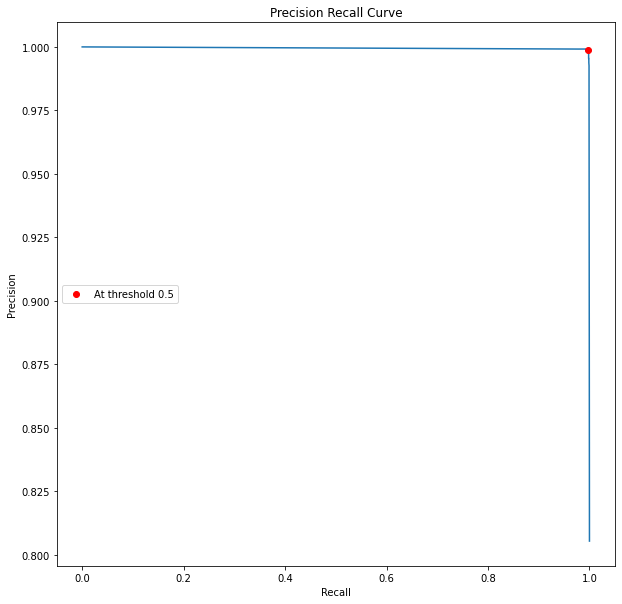

In [140]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(recall_scores, precision_scores)
plt.plot(recall_chosen,precision_chosen,'ro',label="At threshold 0.5") 
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.legend(loc='center left')
plt.title('Precision Recall Curve')

# Compare results of different approaches

In [18]:
models = ["Decision Tree", "Random Forest", "Linear Classification", "Neural Network"]
# because of RAM issue, I couldn't run all cells in one session, so I had to hardcode the result you've seen before here
fprs = [0.4, 0.26666666666666666, 0.13333333333333333 ,0.06666666666666667]
scores = [0.9873333333333333, 0.996, 0.988, 0.8793333172798157]

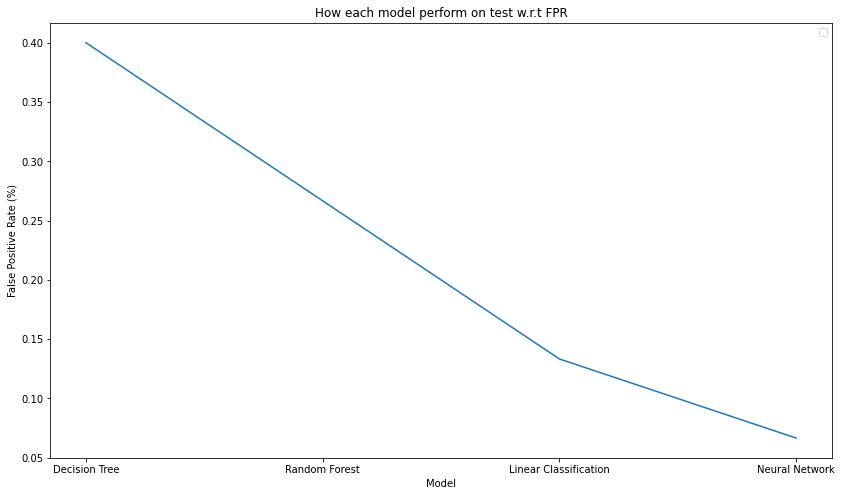

In [21]:
# plot
# figure(figsize=(12, 6), dpi=80)
plt.plot(models,fprs)
plt.title("How each model perform on test w.r.t FPR")
plt.xlabel("Model")
plt.ylabel("False Positive Rate (%)")
plt.legend()
plt.show()


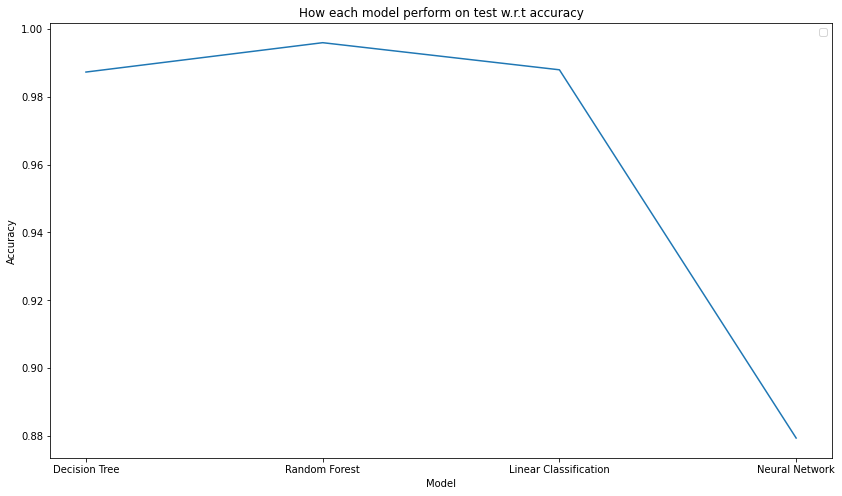

In [22]:
# plot
# figure(figsize=(12, 6), dpi=80)
plt.plot(models,scores)
plt.title("How each model perform on test w.r.t accuracy")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.legend()
plt.show()